In [18]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(font_scale=2)
plt.style.use('seaborn-whitegrid')
%matplotlib inline

import pandas as pd
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Load some data

Here we have 4 different parameters, sepal length/width and petal length/width.  Plus a "true" classification.

In [2]:
iris = sns.load_dataset("iris")
print(iris.shape)


(150, 5)


## Let's look at how the "pair" plots turn out:

Each column is a coordinate axis

In [3]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


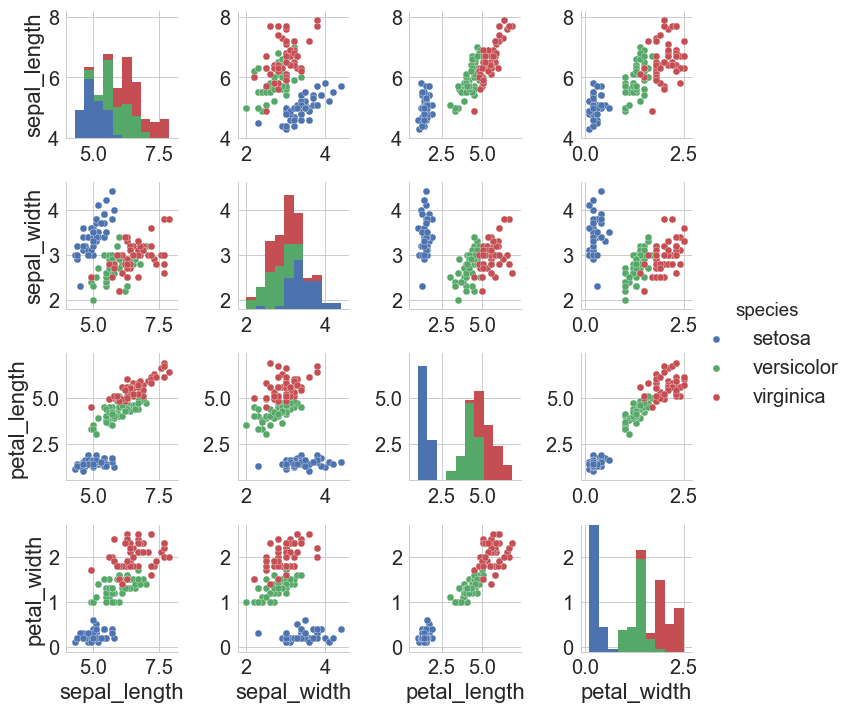

In [4]:
g = sns.pairplot(iris, hue="species")

We can get the mean value and standard deviation of each feature:

In [5]:
print( iris.mean() )

sepal_length    5.843333
sepal_width     3.057333
petal_length    3.758000
petal_width     1.199333
dtype: float64


In [6]:
print( iris.std() )

sepal_length    0.828066
sepal_width     0.435866
petal_length    1.765298
petal_width     0.762238
dtype: float64


## Reduce the feature space

How can we reduce the feature space but still retain the most meaningful information about the features?

We will use Principal Component Analysis (PCA), which finds the directions of maximum variance in high-dimensional data, and projects it into a smaller dimensional subspace.

Let us walk throught the steps of obtaining the principal components:

1) **X**: shifted dataset (each feature has mean value of zero)

In [7]:
X = iris.iloc[:,:4] - iris.iloc[:,:4].mean()

2) Decide whether or not to standardize. If you want to standardize, divide each observation in a column by that column’s standard deviation. In this new dataset **Z** each feature has mean zero and standard deviation 1.

This decision depends on the problem you are solving (it is a modeling choice!). If some variables have a large variance and some small, since PCA maximizes the variance, it will weight more the features with large variance.  If you want your PCA to be independent of the variance, standardizing the features will do that. 

**Z**: shifted and standardized dataset (each feature has mean value of zero and standard deviation 1)


In [8]:
Z = X / iris.iloc[:,:4].std()

### Using SVD:

In [9]:
U, S, Vt = np.linalg.svd(Z, full_matrices=False)
print("Size X = ", X.shape)
print("Size Sigma = ",S.shape)
print("Size U = ",U.shape)
print("Size Vt = ",Vt.shape)
print(S)
variances = S**2
V = Vt.T

Size X =  (150, 4)
Size Sigma =  (4,)
Size U =  (150, 4)
Size Vt =  (4, 4)
[ 20.85320538  11.67007028   4.6761923    1.75684679]


[72.962445413299889, 22.850761786701746, 3.668921889282871, 0.51787091071547942]


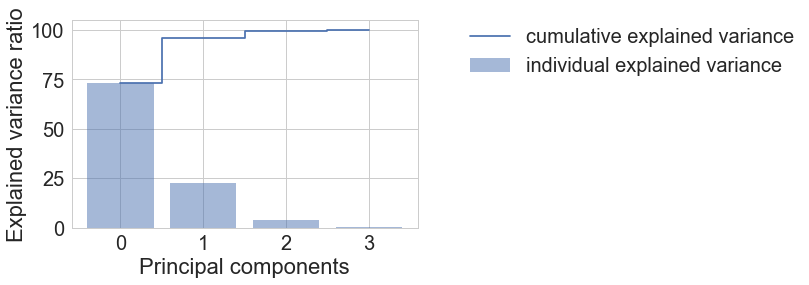

In [10]:
tot = sum(variances)
var_exp = [(i / tot)*100 for i in variances]
cum_var_exp = np.cumsum(var_exp)
print(var_exp)


plt.bar(range(4), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
plt.step(range(4), cum_var_exp, where='mid',
             label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()

In [11]:
Zstar = Z@V[:,:2]

In [12]:
iris['p0'] = Zstar[:,0]
iris['p1'] = Zstar[:,1]

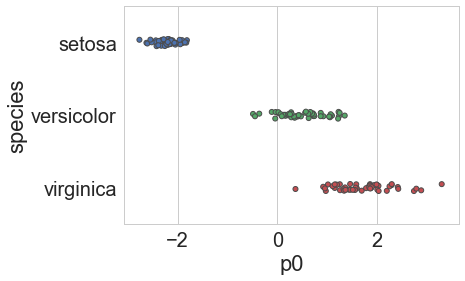

In [13]:
sns.stripplot(x="p0",y="species", data=iris, jitter=0.05, linewidth=1)

In [14]:
def plot_arrow(vector,scale,text_label,text_posx,text_posy):
    plt.arrow(0, 0, scale*vector[0], scale*vector[1], head_width=0.1, head_length=0.1, fc='r', ec='r', lw=5)
    plt.text(scale*vector[0]*text_posx, scale*vector[1]*text_posy, text_label , color='black', ha='center', va='center', fontsize=18)

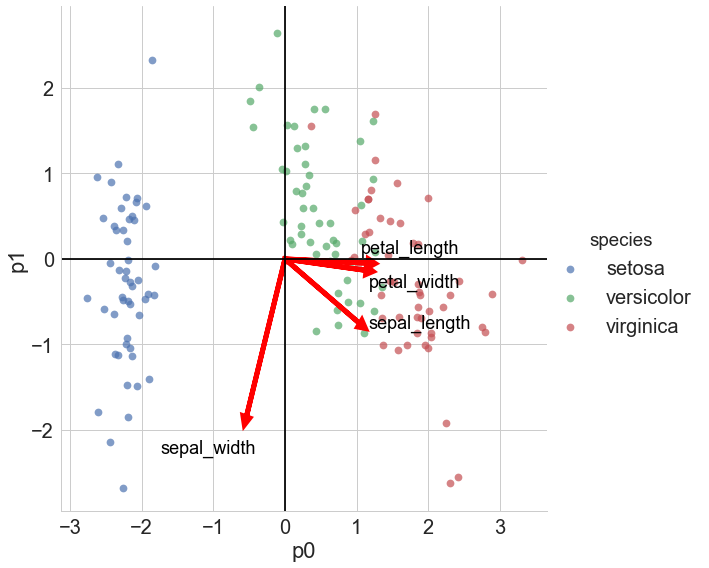

In [15]:

g1 = sns.lmplot('p0', 'p1', iris, hue='species', fit_reg=False, size=8, scatter_kws={'alpha':0.7,'s':60})

ax = g1.axes[0,0]
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')

headers = iris.columns.values.tolist()

plot_arrow(V[0,:],2,headers[0],1.8,1)
plot_arrow(V[1,:],2,headers[1],2,1.2)
plot_arrow(V[2,:],2,headers[2],1.5,-2.5)
plot_arrow(V[3,:],2,headers[3],1.6,2)

Text(0.5,1,'influence of original features in p0')

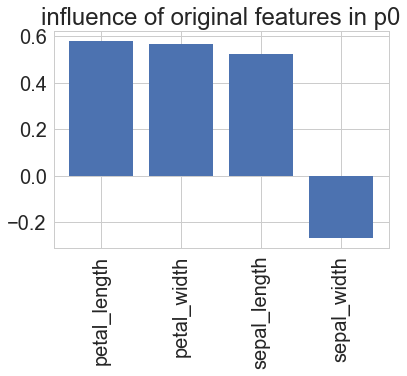

In [16]:
plt.figure()
plt.bar(headers[:4],V[:,0])
plt.xticks(rotation=90)
plt.title('influence of original features in p0')

Text(0.5,1,'influence of original features in p1')

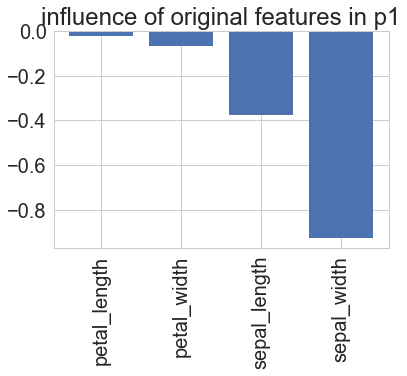

In [17]:
plt.figure()
plt.bar(headers[:4],V[:,1])
plt.xticks(rotation=90)
plt.title('influence of original features in p1')

## Making predictions

In [20]:
X = iris.iloc[:,:4]
Y = iris.iloc[:,4]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)


In [23]:
scoring = 'accuracy'

In [24]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LR: 0.966667 (0.040825)
LDA: 0.975000 (0.038188)
KNN: 0.983333 (0.033333)
CART: 0.966667 (0.040825)
NB: 0.975000 (0.053359)
SVM: 0.991667 (0.025000)


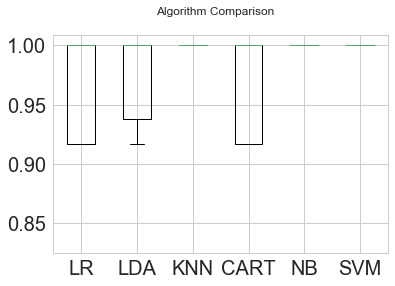

In [28]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [29]:
# Make predictions on validation dataset
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
predictions = knn.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9
[[ 7  0  0]
 [ 0 11  1]
 [ 0  2  9]]
             precision    recall  f1-score   support

     setosa       1.00      1.00      1.00         7
 versicolor       0.85      0.92      0.88        12
  virginica       0.90      0.82      0.86        11

avg / total       0.90      0.90      0.90        30



In [30]:
predictions

array(['virginica', 'versicolor', 'setosa', 'versicolor', 'versicolor',
       'setosa', 'versicolor', 'versicolor', 'setosa', 'versicolor',
       'virginica', 'versicolor', 'setosa', 'virginica', 'setosa',
       'versicolor', 'virginica', 'virginica', 'setosa', 'setosa',
       'versicolor', 'virginica', 'versicolor', 'versicolor', 'virginica',
       'virginica', 'versicolor', 'versicolor', 'virginica', 'virginica'], dtype=object)